In [ ]:
# spark-class org.apache.spark.deploy.master.Master
# spark-class org.apache.spark.deploy.worker.Worker spark://192.168.0.xxx.xxx

In [26]:
#!pip install findspark
#!pip install wordcloud

In [100]:
#!pip install cloudpickle

Defaulting to user installation because normal site-packages is not writeable


In [111]:
import findspark

In [112]:
# đưa link folder spark-bin-hadoop vào đây.
findspark.init('C:\SPARK')

In [113]:
from pyspark import SparkConf

In [114]:
from pyspark import SparkContext

In [115]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import trim
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [116]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local').appName('demoapp').getOrCreate()
spark

In [117]:
df1 = spark.read.format("csv").option("header", "true").load("hdfs://localhost:9000/mydata/my_data.csv")
df2 = spark.read.format("csv").option("header","true").load("hdfs://localhost:9000/mydata/my_data2.csv")
df1.show()

+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------------+----+--------------------+-----------+-----------+-------------+--------------------+-------------------+---------------+
|conversation_id_str|          created_at|favorite_count|           full_text|             id_str|           image_url|in_reply_to_screen_name|lang|            location|quote_count|reply_count|retweet_count|           tweet_url|        user_id_str|       username|
+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------------+----+--------------------+-----------+-----------+-------------+--------------------+-------------------+---------------+
|1761345766055125008|Sat Feb 24 11:02:...|            11|The girlfrienism ...|1761345766055125008|https://pbs.twimg...|                   null|  en|            Malaysia|          0|          0|            

In [118]:
df2.show()

+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------------+----+--------------------+-----------+-----------+-------------+--------------------+-------------------+---------------+
|conversation_id_str|          created_at|favorite_count|           full_text|             id_str|           image_url|in_reply_to_screen_name|lang|            location|quote_count|reply_count|retweet_count|           tweet_url|        user_id_str|       username|
+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------------+----+--------------------+-----------+-----------+-------------+--------------------+-------------------+---------------+
|1761339209040773465|Sat Feb 24 10:36:...|             5|st saw the Rapper...|1761339209040773465|https://pbs.twimg...|                   null|  en|            Pakistan|          0|         12|            

### Vì bộ data 2 crawl sau vào thời điểm twitter update DB nên có thêm 1 cột mới, cần xóa đi để concate với data cũ vì không thích hợp để phân tích

In [119]:
df2 = df2.drop("in_reply_to_screen_name")

### Concate data

In [120]:
df1 = df1.select(df2.columns)
df = df1.union(df2)

In [121]:
df.show()

+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+----+--------------------+-----------+-----------+-------------+--------------------+-------------------+---------------+
|conversation_id_str|          created_at|favorite_count|           full_text|             id_str|           image_url|lang|            location|quote_count|reply_count|retweet_count|           tweet_url|        user_id_str|       username|
+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+----+--------------------+-----------+-----------+-------------+--------------------+-------------------+---------------+
|1761345766055125008|Sat Feb 24 11:02:...|            11|The girlfrienism ...|1761345766055125008|https://pbs.twimg...|  en|            Malaysia|          0|          0|            8|https://twitter.c...| 700962786247995392|     redvelsss_|
|1761345670060167353|Sat Feb 24 11:0

# Phân tích tổng quan trên data

In [122]:
# Đếm số lượng hàng trước khi loại bỏ trùng lặp
row_count_before = df.count()

# Loại bỏ các hàng trùng lặp
df_no_duplicates = df.dropDuplicates()

row_count_after = df_no_duplicates.count()

if row_count_before == row_count_after:
    print("Không có hàng trùng lặp trong DataFrame.")
else:
    print("Đã loại bỏ các hàng trùng lặp.")

# In ra số lượng hàng trước và sau khi loại bỏ trùng lặp
print("Số lượng hàng trước khi loại bỏ trùng lặp:", row_count_before)
print("Số lượng hàng sau khi loại bỏ trùng lặp:", row_count_after)
df = df_no_duplicates

Đã loại bỏ các hàng trùng lặp.
Số lượng hàng trước khi loại bỏ trùng lặp: 12829
Số lượng hàng sau khi loại bỏ trùng lặp: 8672


### Thực hiện phân tích dựa trên nội dung bài đăng

In [123]:
full_text = df.select("full_text")

full_text.show()

+--------------------+
|           full_text|
+--------------------+
|Tried my new NatG...|
|About today punja...|
|LMAAAAO WTF IS TH...|
|Good afternoon ev...|
|Only in ncr https...|
|Men settle where ...|
|Judgement Day pul...|
|Set up https://t....|
|city mooties I sh...|
|THE CROWD IS SO S...|
|PLANE JANE MISS J...|
|Good morning keep...|
|Attention auto de...|
|This is South Afr...|
|Black Ke Colour Y...|
|On the train to D...|
|More sources writ...|
|Cassin's Kingbird...|
|She is from Bulaw...|
|i forgot toland c...|
+--------------------+
only showing top 20 rows



### Loại bỏ link trong các content

In [124]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col

# Loại bỏ các đường link từ cột "full_text"
full_text = full_text.withColumn("full_text", regexp_replace(col("full_text"), "http\\S+", ""))
full_text = full_text.withColumn("full_text", regexp_replace("full_text", "[^\\x00-\\x7F]", ""))

full_text.show()

+--------------------+
|           full_text|
+--------------------+
|Tried my new NatG...|
|About today punja...|
|LMAAAAO WTF IS THIS |
|Good afternoon ev...|
|        Only in ncr |
|Men settle where ...|
|Judgement Day pul...|
|             Set up |
|city mooties I sh...|
|THE CROWD IS SO S...|
|PLANE JANE MISS J...|
|Good morning keep...|
|Attention auto de...|
|This is South Afr...|
|Black Ke Colour Y...|
|On the train to D...|
|More sources writ...|
|Cassin's Kingbird...|
|She is from Bulaw...|
|i forgot toland c...|
+--------------------+
only showing top 20 rows



In [125]:
from pyspark.sql.functions import *

# Chuyển tất cả thành lower
full_text = full_text.withColumn("full_text", lower(col("full_text")))

full_text.show()


+--------------------+
|           full_text|
+--------------------+
|tried my new natg...|
|about today punja...|
|lmaaaao wtf is this |
|good afternoon ev...|
|        only in ncr |
|men settle where ...|
|judgement day pul...|
|             set up |
|city mooties i sh...|
|the crowd is so s...|
|plane jane miss j...|
|good morning keep...|
|attention auto de...|
|this is south afr...|
|black ke colour y...|
|on the train to d...|
|more sources writ...|
|cassin's kingbird...|
|she is from bulaw...|
|i forgot toland c...|
+--------------------+
only showing top 20 rows



### Xử lý stop_words

In [126]:
stop_words_df = spark.read.text("stop_words_english.txt")

stop_words_list = [row.value for row in stop_words_df.collect()]

# Broadcast danh sách stop word để sử dụng trong UDF
broadcast_stop_words = spark.sparkContext.broadcast(stop_words_list)

In [127]:
words_df = full_text.select(explode(split(col("full_text"), " ")).alias("word"))

# Filter out the stop words
filtered_fulltext = words_df.filter(~col("word").isin(broadcast_stop_words.value))

filtered_fulltext.show()

+---------+
|     word|
+---------+
|   natgeo|
|   beanie|
|  putting|
|  storage|
|    &amp;|
|     love|
|     snug|
|    head.|
|     love|
|   pointy|
|      bit|
| sticking|
| beanies.|
|#kyungsoo|
| sweating|
|      do.|
|         |
|    today|
|   punjab|
| assembly|
+---------+
only showing top 20 rows



In [128]:
word_count_df = filtered_fulltext.groupBy("word").count()

word_count_df.show()

+-------------+-----+
|         word|count|
+-------------+-----+
|          ...|   93|
|        subiu|    1|
|         hope|   53|
|          art|   22|
|       outfit|   12|
|     nicotine|    1|
|        too!!|    1|
|     everyday|   12|
|      embrace|    4|
|       online|   19|
|         chor|    1|
|       quote:|    1|
|      blossom|    3|
|reintegration|    1|
|     randomly|    1|
|        oscar|    2|
|        turks|    1|
|        trail|    3|
|         lder|    1|
|  handicapped|    1|
+-------------+-----+
only showing top 20 rows



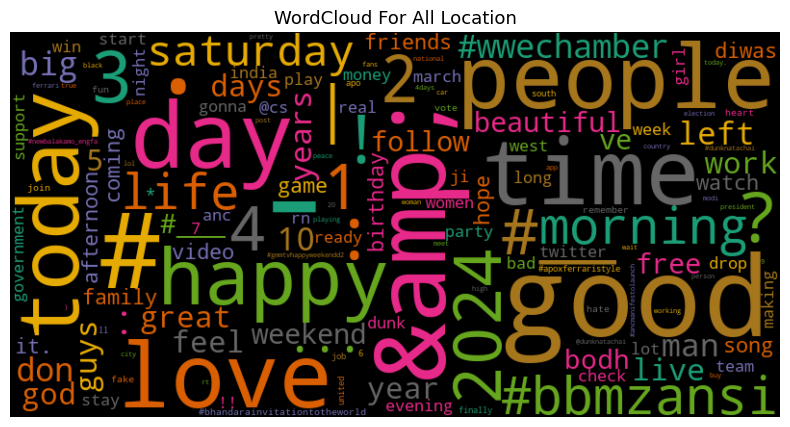

In [129]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textwrap import wrap
# Chuyển DataFrame thành dictionary với 'word' là key và 'count' là value
word_count_dict = word_count_df.rdd.collectAsMap()

# Tạo WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=150,colormap="Dark2").generate_from_frequencies(word_count_dict)

title = "WordCloud For All Location"

# Trực quan
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('\n'.join(wrap(title,60)),fontsize=13)
plt.axis("off")
plt.show()


In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, to_timestamp

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

# Chuyển đổi 'created_at' thành kiểu Timestamp
df = df.withColumn('created_at', to_timestamp(df['created_at'], 'EEE MMM dd HH:mm:ss z yyyy'))

# Tạo 'hour' để lưu trữ giờ của mỗi bài viết
df_time = df.withColumn('hour', hour(df['created_at']))

df_time.show()


+-------------------+-------------------+--------------+--------------------+-------------------+--------------------+----+--------------------+-----------+-----------+-------------+--------------------+-------------------+---------------+----+
|conversation_id_str|         created_at|favorite_count|           full_text|             id_str|           image_url|lang|            location|quote_count|reply_count|retweet_count|           tweet_url|        user_id_str|       username|hour|
+-------------------+-------------------+--------------+--------------------+-------------------+--------------------+----+--------------------+-----------+-----------+-------------+--------------------+-------------------+---------------+----+
|1761340588748619925|2024-02-24 17:41:35|             1|Tried my new NatG...|1761340588748619925|https://pbs.twimg...|  en| Manila, Philippines|          0|          0|            0|https://twitter.c...|           14071373|       nikkio96|  17|
|1761348858750120089

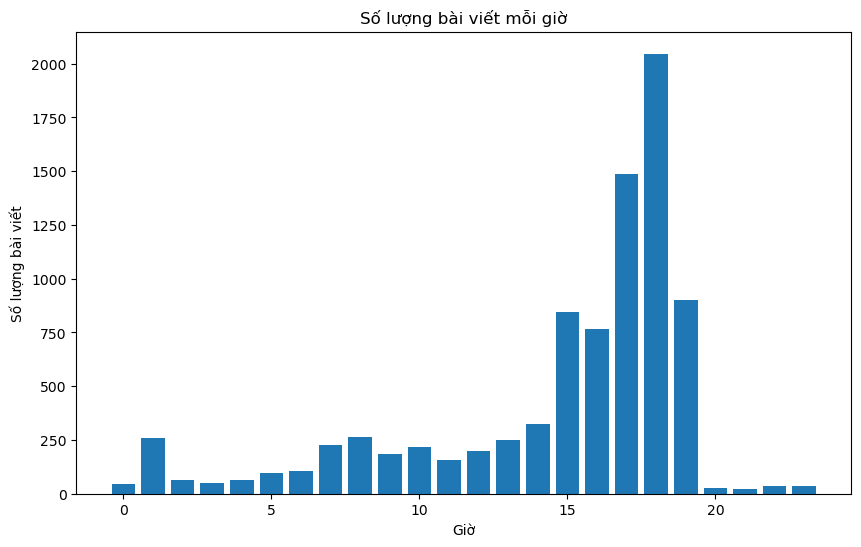

In [111]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

# Nhóm các bài viết theo giờ và đếm số lượng bài viết cho mỗi giờ
post_counts = df_time.groupBy('hour').agg(count('hour').alias('count'))

# Chuyển đổi kết quả thành Pandas DataFrame
post_counts_pandas = post_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(post_counts_pandas['hour'], post_counts_pandas['count'])
plt.xlabel('Giờ')
plt.ylabel('Số lượng bài viết')
plt.title('Số lượng bài viết mỗi giờ')
plt.show()


In [112]:
from pyspark.sql.functions import date_format

df_time = df_time.withColumn('weekday', date_format(df['created_at'], 'E'))


In [113]:
df_time.dropna(subset=['weekday'])

DataFrame[conversation_id_str: string, created_at: timestamp, favorite_count: string, full_text: string, id_str: string, image_url: string, lang: string, location: string, quote_count: string, reply_count: string, retweet_count: string, tweet_url: string, user_id_str: string, username: string, hour: int, weekday: string]

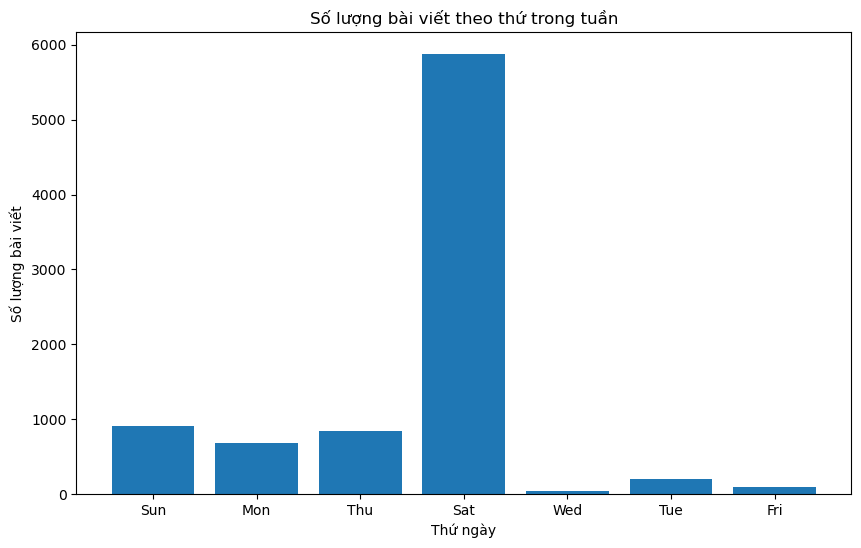

In [114]:
weekday_counts.dropna(subset=['weekday'], inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(weekday_counts['weekday'], weekday_counts['count'])
plt.xlabel('Thứ ngày')
plt.ylabel('Số lượng bài viết')
plt.title('Số lượng bài viết theo thứ trong tuần')
plt.show()

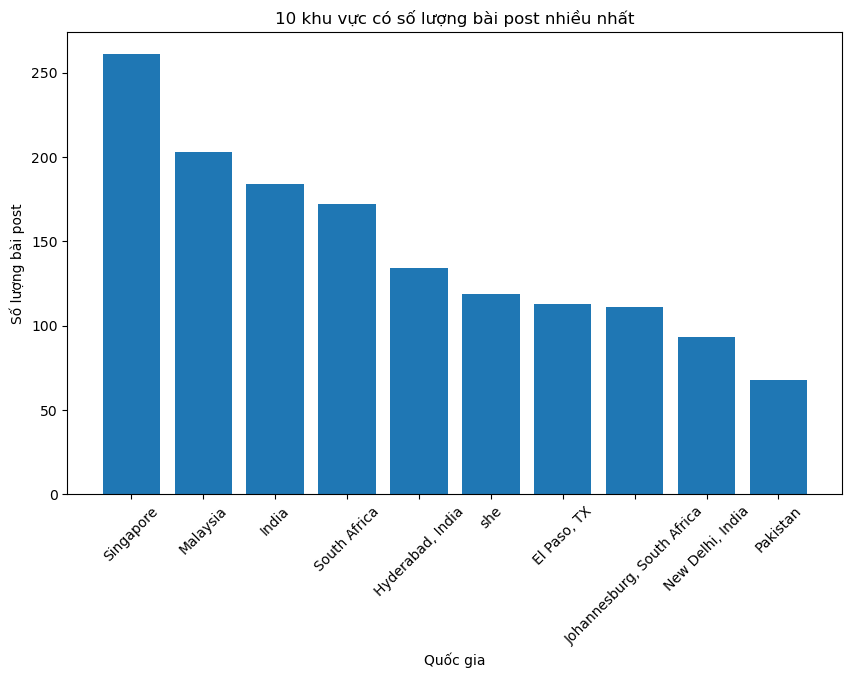

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as F

# Tính tổng số lượng bài post cho mỗi quốc gia
post_counts = df.groupBy("location").count()

# Sắp xếp theo số lượng bài post giảm dần
sorted_post_counts = post_counts.orderBy(F.desc("count"))

# Chuyển đổi DataFrame Spark thành DataFrame Pandas để trực quan hóa
top_countries = sorted_post_counts.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_countries['location'], top_countries['count'])
plt.xlabel('Quốc gia')
plt.ylabel('Số lượng bài post')
plt.title('10 khu vực có số lượng bài post nhiều nhất')
plt.xticks(rotation=45)
plt.show()


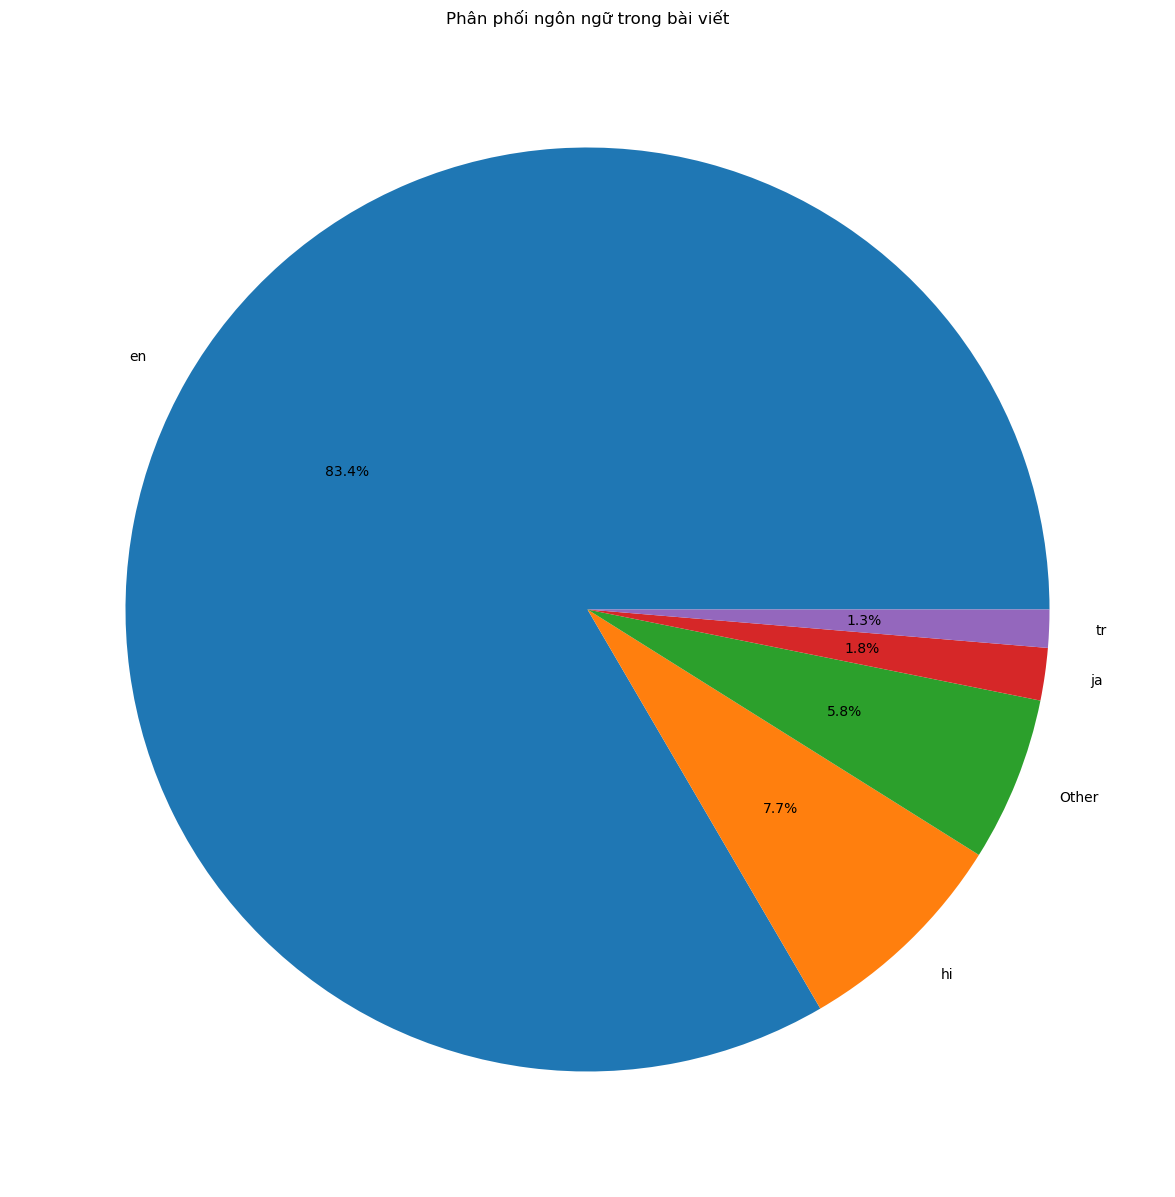

In [132]:
from pyspark.sql.functions import desc

lang_counts = df.groupBy('lang').count().orderBy(desc('count'))

# Lấy 4 ngôn ngữ phổ biến nhất
top_lang_list = [row['lang'] for row in lang_counts.take(4)]

# các ngôn ngữ không thuộc top 4
df_with_category = df.withColumn("language_category", F.when(df["lang"].isin(top_lang_list), df["lang"]).otherwise("Other"))

# Tính tổng số lượng bài post cho từng loại ngôn ngữ
lang_category_counts = df_with_category.groupBy("language_category").count().orderBy(desc("count"))

lang_category_counts_pd = lang_category_counts.toPandas()

# Pie Chart
plt.figure(figsize=(15, 15))
plt.pie(lang_category_counts_pd['count'], labels=lang_category_counts_pd['language_category'], autopct='%1.1f%%')
plt.title('Phân phối ngôn ngữ trong bài viết')
plt.show()

- Ngôn ngữ của các bài viết đa phần là en nên ta sẽ sử dụng chủ yếu xử lý và sử dụng trên ngôn ngữ này.
- Một số mẫu data bị lỗi khi cào về

# Phân tích trên 4 khu vực top đầu

In [105]:
from pyspark.sql.functions import col, count
from pyspark.sql.window import Window

window = Window.partitionBy('location')

df = df.withColumn('count', count('*').over(window))

df_filtered = df.filter(col('count') > 150)

df_filtered.show()

+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+----+--------+-----------+-----------+-------------+--------------------+-------------------+---------------+-----+
|conversation_id_str|          created_at|favorite_count|           full_text|             id_str|           image_url|lang|location|quote_count|reply_count|retweet_count|           tweet_url|        user_id_str|       username|count|
+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+----+--------+-----------+-----------+-------------+--------------------+-------------------+---------------+-----+
|1761340093120291194|Sat Feb 24 10:39:...|             1|The sound decibel...|1761340093120291194|https://pbs.twimg...|  en|   India|          0|          0|            1|https://twitter.c...|          370559808| EbrahimNasreen|  184|
|1761365091239289275|Sat Feb 24 12:18:...|             5|My 

In [106]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col

# Loại bỏ các đường link từ cột "full_text"
df_filtered = df_filtered.withColumn("full_text", regexp_replace(col("full_text"), "http\\S+", ""))
df_filtered = df_filtered.withColumn("full_text", regexp_replace("full_text", "[^\\x00-\\x7F]", ""))

# Hiển thị kết quả
df_filtered.show()

+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+----+--------+-----------+-----------+-------------+--------------------+-------------------+---------------+-----+
|conversation_id_str|          created_at|favorite_count|           full_text|             id_str|           image_url|lang|location|quote_count|reply_count|retweet_count|           tweet_url|        user_id_str|       username|count|
+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+----+--------+-----------+-----------+-------------+--------------------+-------------------+---------------+-----+
|1761340093120291194|Sat Feb 24 10:39:...|             1|The sound decibel...|1761340093120291194|https://pbs.twimg...|  en|   India|          0|          0|            1|https://twitter.c...|          370559808| EbrahimNasreen|  184|
|1761365091239289275|Sat Feb 24 12:18:...|             5|My 

In [107]:
from pyspark.sql.functions import *

df_filtered = df_filtered.withColumn("full_text", lower(col("full_text")))

In [108]:
words_df = df_filtered.select(explode(split(col("full_text"), " ")).alias("word"))

# Lọc ra các từ không phải stop word
filtered_words = words_df.filter(~col("word").isin(broadcast_stop_words.value))

filtered_words.show()

+--------------+
|          word|
+--------------+
|         sound|
|       decibel|
|          high|
|        result|
|       hearing|
|        damage|
|           ear|
|         drums|
|substantially.|
|        indian|
|       farmers|
|       treated|
|    terrorists|
|   government.|
|              |
|        friend|
|        opened|
|          shop|
|    girlfriend|
|      customer|
+--------------+
only showing top 20 rows



In [109]:
word_count_df = filtered_words.groupBy("word").count()
word_count_df.show()

+-----------+-----+
|       word|count|
+-----------+-----+
|     quote:|    1|
|      trail|    1|
|interaction|    1|
|    lyrical|    1|
|  librarian|    1|
|       hope|    6|
|   everyday|    2|
|     outfit|    8|
|      too!!|    1|
|        qrt|    1|
|     jihoon|    2|
|         c.|    1|
|        art|    6|
|   lappland|    1|
|     welkom|    1|
|        ...|    1|
|     ransom|    1|
|     launch|    2|
|      staff|    2|
|    highest|    1|
+-----------+-----+
only showing top 20 rows



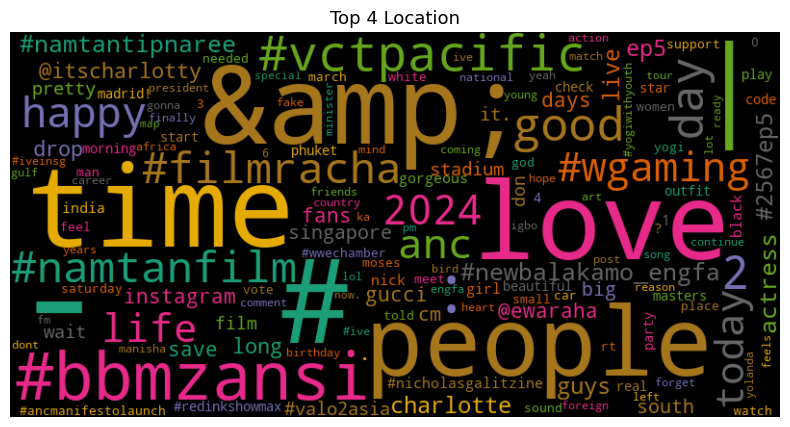

In [110]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textwrap import wrap
# Chuyển DataFrame thành dictionary với 'word' là key và 'count' là value
word_count_dict = word_count_df.rdd.collectAsMap()

wordcloud = WordCloud(width=800, height=400, max_words=150,colormap="Dark2").generate_from_frequencies(word_count_dict)

title = "Top 4 Location"

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('\n'.join(wrap(title,60)),fontsize=13)
plt.axis("off")
plt.show()


# Singapore Location

In [130]:
df_singapore = df.filter(col('location') == 'Singapore')

In [131]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col

# Loại bỏ các đường link từ cột "full_text"
df_singapore = df_singapore.withColumn("full_text", regexp_replace(col("full_text"), "http\\S+", ""))


In [100]:
df_singapore = df_singapore.withColumn("full_text", regexp_replace("full_text", "[^\\x00-\\x7F]", ""))

# Show the DataFrame
df_singapore.show()


+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+----+---------+-----------+-----------+-------------+--------------------+-------------------+---------------+-----+
|conversation_id_str|          created_at|favorite_count|           full_text|             id_str|           image_url|lang| location|quote_count|reply_count|retweet_count|           tweet_url|        user_id_str|       username|count|
+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+----+---------+-----------+-----------+-------------+--------------------+-------------------+---------------+-----+
|1750443685605753325|Thu Jan 25 09:01:...|             4|Cassin's Kingbird...|1750443685605753325|https://pbs.twimg...|  en|Singapore|          0|          0|            0|https://twitter.c...|1715364886728110080|MohammedSa53720|  261|
|1761336895374516541|Sat Feb 24 10:26:...|             2

In [101]:
from pyspark.sql.functions import *
# Chuyển tất cả thành lower case
df_filtered = df_singapore.withColumn("full_text", lower(col("full_text")))

In [102]:
words_df = df_filtered.select(explode(split(col("full_text"), " ")).alias("word"))

# Lọc ra các từ không phải là stop word
filtered_words = words_df.filter(~col("word").isin(broadcast_stop_words.value))

# Hiển thị kết quả
filtered_words.show()

+----------+
|      word|
+----------+
|  cassin's|
|  kingbird|
|  striking|
|      bird|
|   western|
|     north|
|  america.|
|      bold|
|     black|
|      mask|
|   vibrant|
|    yellow|
|underparts|
|          |
|     adept|
|  catching|
|    flying|
|   insects|
|    aerial|
|   forays.|
+----------+
only showing top 20 rows



In [103]:
# Perform map reduce to count the occurrence of each word
word_count_df = filtered_words.groupBy("word").count()

# Display the result
word_count_df.show()


+-------------+-----+
|         word|count|
+-------------+-----+
|       outfit|    3|
|         hope|    1|
|          art|    1|
|     lappland|    1|
|      #citex.|    1|
|     positive|    1|
|           's|    1|
|    habitats.|    1|
|wheein???!!!!|    1|
|          map|    5|
|        plane|    1|
|        watch|    1|
|    tomorrow.|    3|
|         cook|    1|
|       charts|    1|
|        deeds|    1|
|        (core|    1|
|  fantasy."""|    1|
|            7|    1|
|       #mwc24|    1|
+-------------+-----+
only showing top 20 rows



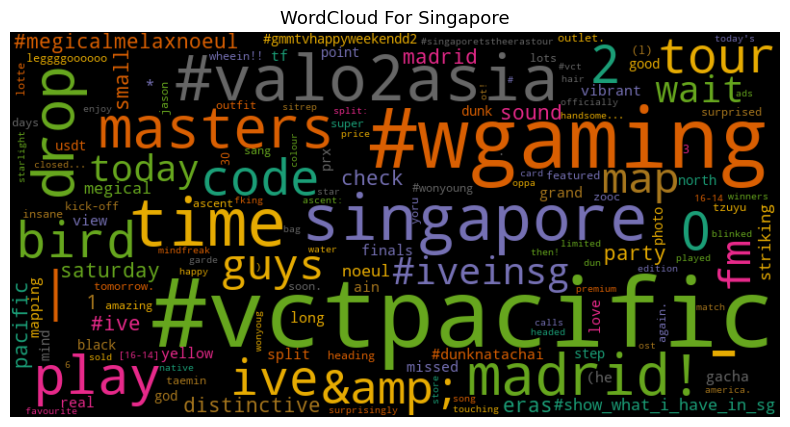

In [104]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textwrap import wrap
# Chuyển DataFrame thành dictionary với 'word' là key và 'count' là value
word_count_dict = word_count_df.rdd.collectAsMap()

# Tạo một đối tượng WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=150,colormap="Dark2").generate_from_frequencies(word_count_dict)

# Định nghĩa tiêu đề
title = "WordCloud For Singapore"

# Trực quan hóa WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('\n'.join(wrap(title,60)),fontsize=13)
plt.axis("off")
plt.show()


In [90]:
#spark.stop()